# Quantum RBM training on the OptDigits Dataset for reconstruction and classification
This is an example on quantum annealing training of an RBM on the OptDigits
dataset.
Developed by: Jose Pinilla

In [1]:
# Required packages
import qaml
import torch
torch.manual_seed(0) # For deterministic weights

import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms


In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (8,8)
EPOCHS = 75
BATCH_SIZE = 1024
SUBCLASSES = [1,2,3,4]
DATA_SIZE = N*M
LABEL_SIZE = len(SUBCLASSES)
# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5


Using downloaded and verified file ./data/OptDigits\raw\optdigits.tra
Using downloaded and verified file ./data/OptDigits\raw\optdigits.tes


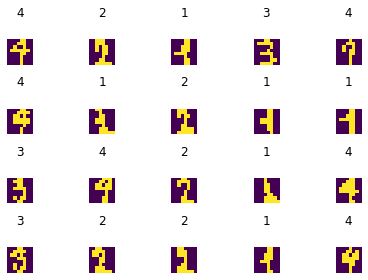

In [3]:
#################################### Input Data ################################
train_dataset = qaml.datasets.OptDigits(root='./data/', train=True,
                                     transform=torch_transforms.Compose([
                                     torch_transforms.ToTensor(),
                                     lambda x:(x>0.5).to(x.dtype)]), #Binarize
                                     target_transform=torch_transforms.Compose([
                                     lambda x:torch.LongTensor([x.astype(int)]),
                                     lambda x:F.one_hot(x-1,len(SUBCLASSES))]),
                                     download=True)

train_idx = [i for i,y in enumerate(train_dataset.targets) if y in SUBCLASSES]
sampler = torch.utils.data.SubsetRandomSampler(train_idx)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           sampler=sampler)

fig,axs = plt.subplots(4,5)
subdataset = zip(train_dataset.data[train_idx],train_dataset.targets[train_idx])
for ax,(img,label) in zip(axs.flat,subdataset):
    ax.matshow(img>0.5)
    ax.set_title(int(label))
    ax.axis('off')
plt.tight_layout()

test_dataset = qaml.datasets.OptDigits(root='./data/', train=False,
                                    transform=torch_transforms.Compose([
                                    torch_transforms.ToTensor(),
                                    lambda x:(x>0.5).to(x.dtype)]), #Binarize
                                    target_transform=torch_transforms.Compose([
                                    lambda x:torch.LongTensor([x.astype(int)]),
                                    lambda x:F.one_hot(x-1,len(SUBCLASSES))]),
                                    download=True)

test_idx = [i for i,y in enumerate(test_dataset.targets) if y in SUBCLASSES]
sampler = torch.utils.data.SubsetRandomSampler(test_idx)
test_loader = torch.utils.data.DataLoader(test_dataset,sampler=sampler)


In [4]:
################################# Model Definition #############################
VISIBLE_SIZE = DATA_SIZE + LABEL_SIZE
HIDDEN_SIZE = 16

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE,HIDDEN_SIZE)

# Initialize biases
torch.nn.init.uniform_(rbm.b,-0.1,0.1)
torch.nn.init.uniform_(rbm.c,-0.1,0.1)
torch.nn.init.uniform_(rbm.W,-0.1,0.1)

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate,
                            weight_decay=weight_decay,momentum=momentum)

# Set up training mechanisms
solver_name = "Advantage_system1.1"
qa_sampler = qaml.sampler.QASampler(rbm,solver=solver_name,beta=2.5)

# Loss and autograd
CD = qaml.autograd.SampleBasedConstrastiveDivergence()


In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
scalar_log = []
accuracy_log = []
b_log = [rbm.b.detach().clone().numpy()]
c_log = [rbm.c.detach().clone().numpy()]
W_log = [rbm.W.detach().clone().numpy().flatten()]
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])

    for img_batch, labels_batch in train_loader:
        input_data = torch.cat((img_batch.flatten(1),labels_batch.flatten(1)),1)

        # Positive Phase
        v0,prob_h0 = input_data,rbm(input_data,scale=qa_sampler.beta)
        # Negative Phase
        vk, prob_hk = qa_sampler(BATCH_SIZE,auto_scale=True)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply((v0,prob_h0), (vk,prob_hk), *rbm.parameters())

        # Do not accumulate gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err

    # Error Log
    b_log.append(rbm.b.detach().clone().numpy())
    c_log.append(rbm.c.detach().clone().numpy())
    W_log.append(rbm.W.detach().clone().numpy().flatten())
    err_log.append(epoch_error.item())
    scalar_log.append(qa_sampler.scalar)
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")
    ############################## CLASSIFICATION ##################################
    count = 0
    for i,(test_data, test_label) in enumerate(test_loader):
        prob_hk = rbm(torch.cat((test_data.flatten(1),torch.zeros(1,LABEL_SIZE)),dim=1))
        data_pred,label_pred = rbm.generate(prob_hk).split((DATA_SIZE,LABEL_SIZE),dim=1)
        if label_pred.argmax() == test_label.argmax():
            count+=1
    accuracy_log.append(count/len(test_idx))
    print(f"Testing accuracy: {count}/{len(test_idx)} ({count/len(test_idx):.2f})")


Epoch 0 Reconstruction Error = 43.48208999633789
Testing accuracy: 177/723 (0.24)
Epoch 1 Reconstruction Error = 15.160688400268555
Testing accuracy: 177/723 (0.24)
Epoch 2 Reconstruction Error = 10.371027946472168
Testing accuracy: 177/723 (0.24)
Epoch 3 Reconstruction Error = 7.103804588317871
Testing accuracy: 177/723 (0.24)
Epoch 4 Reconstruction Error = 5.564914226531982
Testing accuracy: 183/723 (0.25)
Epoch 5 Reconstruction Error = 5.09861421585083
Testing accuracy: 302/723 (0.42)
Epoch 6 Reconstruction Error = 5.85688591003418
Testing accuracy: 177/723 (0.24)
Epoch 7 Reconstruction Error = 4.435452938079834
Testing accuracy: 177/723 (0.24)
Epoch 8 Reconstruction Error = 5.444918632507324
Testing accuracy: 177/723 (0.24)
Epoch 9 Reconstruction Error = 5.392329216003418
Testing accuracy: 224/723 (0.31)
Epoch 10 Reconstruction Error = 7.662173271179199
Testing accuracy: 230/723 (0.32)
Epoch 11 Reconstruction Error = 7.4741010665893555
Testing accuracy: 425/723 (0.59)
Epoch 12 Reco

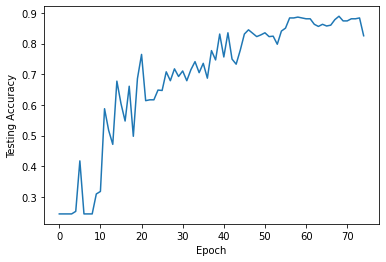

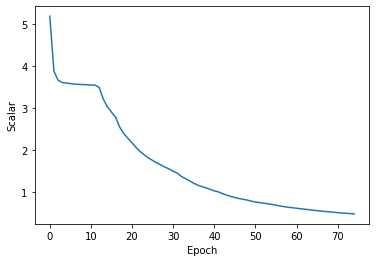

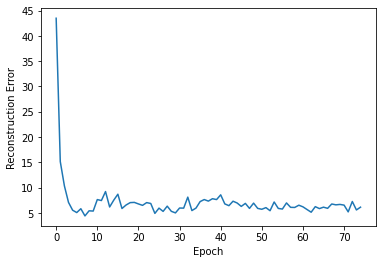

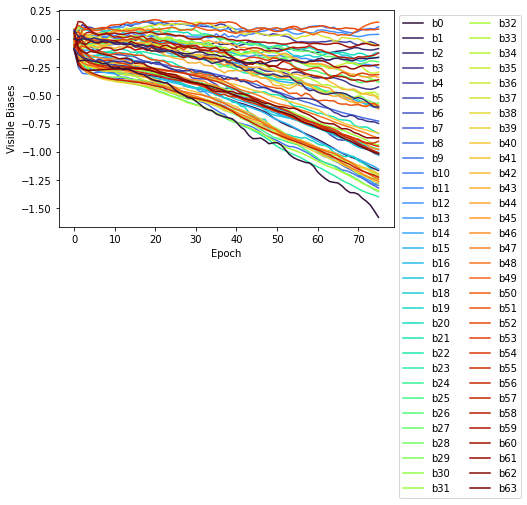

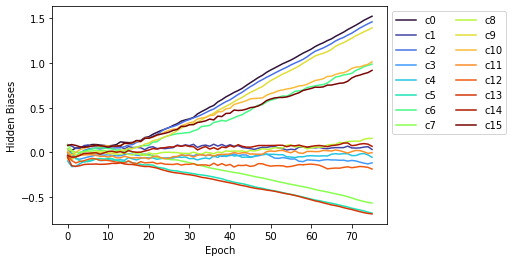

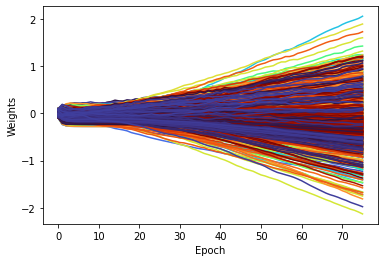

In [8]:
############################ MODEL VISUALIZATION ###############################

# Testing accuracy graph
fig, ax = plt.subplots()
plt.plot(accuracy_log)
plt.ylabel("Testing Accuracy")
plt.xlabel("Epoch")
plt.savefig("quantum_accuracy.pdf")

# Scalar graph
fig, ax = plt.subplots()
plt.plot(scalar_log)
plt.ylabel("Scalar")
plt.xlabel("Epoch")
plt.savefig("alpha.pdf")

# Error graph
fig, ax = plt.subplots()
plt.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")
plt.savefig("quantum_err.pdf")

# Visible bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',DATA_SIZE).colors))
lc_v = ax.plot(b_log)
plt.legend(iter(lc_v),[f'b{i}' for i in range(DATA_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Visible Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_visible_bias_log.pdf")

# Hidden bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE).colors))
lc_h = plt.plot(c_log)
plt.legend(lc_h,[f'c{i}' for i in range(HIDDEN_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Hidden Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_hidden_bias_log.pdf")

# Weights graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE*DATA_SIZE).colors))
lc_w = plt.plot(W_log)
plt.ylabel("Weights")
plt.xlabel("Epoch")
plt.savefig("quantum_weights_log.pdf")


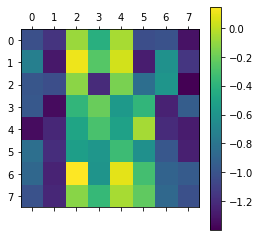

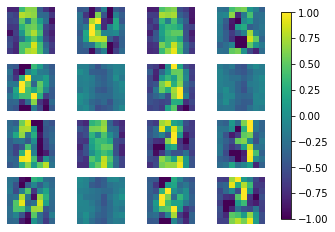

In [9]:
################################## VISUALIZE ###################################
plt.matshow(rbm.b.detach()[:DATA_SIZE].view(*SHAPE), cmap='viridis')
plt.colorbar()

fig,axs = plt.subplots(HIDDEN_SIZE//4,4)
for i,ax in enumerate(axs.flat):
    weight_matrix = rbm.W[i].detach()[:DATA_SIZE].view(*SHAPE)
    ms = ax.matshow(weight_matrix, cmap='viridis', vmin=-1, vmax=1)
    ax.axis('off')
cbar = fig.colorbar(ms, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig("quantum_weights.pdf")